In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import ndimage
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.display import clear_output

import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


## Data

In [2]:
def prepare_data(image_size, random_state=1):
    labels = pd.read_csv('./data/labels.csv')
    sample_submission = pd.read_csv('./data/sample_submission.csv')
    print('Train data size:', labels.shape[0])
    print('Test data size:', sample_submission.shape[0])
    labels_one_hot = np.array(pd.get_dummies(labels['breed'], sparse=True))
    
    x_train = []
    y_train = []
    x_test = []
    
    for i, id in enumerate(labels['id']):
        image = np.array(ndimage.imread('./data/train/' + id + '.jpg', flatten=False))
        x_train.append(scipy.misc.imresize(image, size=(image_size, image_size)))
        y_train.append(labels_one_hot[i])
        if (i % 1000 == 0) and (i != 0):
            print(i, 'images processed')

    for i, id in enumerate(sample_submission['id']):
        image = np.array(ndimage.imread('./data/test/' + id + '.jpg', flatten=False))
        x_test.append(scipy.misc.imresize(image, size=(image_size, image_size)))
        if (i % 1000 == 0) and (i != 0):
            print(i, 'images processed')
                
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    
    X_train, X_dev, Y_train, Y_dev = train_test_split(x_train, y_train, test_size=0.3, random_state=random_state)
                
    np.save('./data/raw/X_train', X_train)
    np.save('./data/raw/Y_train', Y_train)
    np.save('./data/raw/X_dev', X_dev)
    np.save('./data/raw/Y_dev', Y_dev)
    np.save('./data/raw/x_test', x_test)

    print('Train dataset:', x_train.shape)
    print('Train labels:', y_train.shape)
    print('Test dataset:', x_test.shape)
    
    return None

def load (name, normalize):
    data = np.load('./data/raw/' + name + '.npy')
    if normalize == True:
        data = data / 255
    return data

In [3]:
image_size = 90
input_size = (image_size, image_size, 3)
num_class = 120

In [4]:
#execute only once
prepare_data(image_size)

Train data size: 10222
Test data size: 10357


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


ValueError: 'arr' does not have a suitable array shape for any mode.

In [4]:
X_train = load('X_train', normalize=True)
Y_train = load('Y_train', normalize=False)

X_dev = load('X_dev', normalize=True)
Y_dev = load('Y_dev', normalize=False)

## Callbacks

In [5]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)
        self.ax1 = ax1
        self.ax2 = ax2
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        self.ax1.plot(self.x, self.losses, label="loss")
        self.ax1.plot(self.x, self.val_losses, label="val loss")
        self.ax1.legend()
        self.ax2.plot(self.x, self.acc, label="accuracy")
        self.ax2.plot(self.x, self.val_acc, label="val accuracy")
        self.ax2.legend()
        plt.show()
        
        for i in range(self.i):
            print('Epoch ' + str(i+1))
            print('-----------------------')
            print('- Loss:', self.losses[i])
            print('- Accuracy:', self.acc[i])
            print('- Validation loss:', self.val_losses[i])
            print('- Validation accuracy:', self.val_acc[i])
            print(' ')

## AlexNet

In [6]:
X_input = Input(input_size)

X = Conv2D(96, (11, 11), strides=(4,4), activation='relu')(X_input)
X = MaxPooling2D((3,3), strides=(2,2))(X)
X = Conv2D(256, (5,5), padding='same', activation='relu')(X)
X = MaxPooling2D((3,3), strides=(2,2))(X)
X = Conv2D(384, (3,3), padding='same', activation='relu')(X)
X = Conv2D(384, (3,3), padding='same', activation='relu')(X)
X = Conv2D(256, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D((3,3), strides=(2,2))(X)

X = Flatten()(X)
X = Dense(1024, activation='relu')(X)
X = Dense(512, activation='relu')(X)
output = Dense(120, activation='softmax')(X)

model = Model(inputs=X_input, outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train,
          batch_size=512,
          epochs=100,
          verbose=1)

Epoch 1/100
7155/7155 [==============================] - 97s 14ms/step - loss: 4.7891 - acc: 0.0067
Epoch 2/100
7155/7155 [==============================] - 96s 13ms/step - loss: 4.7824 - acc: 0.0109
Epoch 3/100
 512/7155 [=>............................] - ETA: 1:22 - loss: 4.7828 - acc: 0.0059

## VGG16 Transfer

In [6]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_size)

X = base_model.output
X = Flatten()(X)
output= Dense(num_class, activation='softmax')(X)

model = Model(inputs=base_model.inputs, outputs=output)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 90, 90, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 90, 90, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 90, 90, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 45, 45, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 45, 45, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 45, 45, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 22, 22, 128)       0         
__________

In [7]:
plot_losses = PlotLosses()

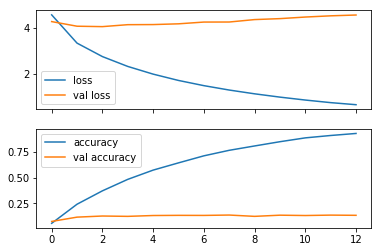

Epoch 1
-----------------------
- Loss: 4.57616182563
- Accuracy: 0.0575821104123
- Validation loss: 4.2811610785
- Validation accuracy: 0.0756439517541
 
Epoch 2
-----------------------
- Loss: 3.33926656441
- Accuracy: 0.242487770794
- Validation loss: 4.07900619553
- Validation accuracy: 0.11737854582
 
Epoch 3
-----------------------
- Loss: 2.75068275217
- Accuracy: 0.372047519217
- Validation loss: 4.06078416531
- Validation accuracy: 0.128138245843
 
Epoch 4
-----------------------
- Loss: 2.31956298823
- Accuracy: 0.483298392732
- Validation loss: 4.14621263177
- Validation accuracy: 0.124877730681
 
Epoch 5
-----------------------
- Loss: 1.98288407597
- Accuracy: 0.572886093641
- Validation loss: 4.15107503643
- Validation accuracy: 0.133029018595
 
Epoch 6
-----------------------
- Loss: 1.70644671122
- Accuracy: 0.643046820409
- Validation loss: 4.18374186546
- Validation accuracy: 0.134659276185
 
Epoch 7
-----------------------
- Loss: 1.47891537616
- Accuracy: 0.71125087

KeyboardInterrupt: 

In [8]:
model.fit(X_train, Y_train,
          batch_size=16,
          epochs=20,
          verbose=1,
          callbacks=[plot_losses], 
          validation_data=(X_dev, Y_dev))